In [61]:
#needed libraries

import sys as sys
import pandas as pd
import numpy as np
import itertools
import pickle
import matplotlib.pyplot as plt



In [62]:

#Please import your data file into the box below. Ensure it is a CSV file containing columns
#for tile coordinates, number of produced mRNAs in the experiment, and the libvalue for each tile.
#The file should include the following columns: 'start', 'end', 'count', and 'lib'. Coordinate values should be in base pairs. 
#There is a sample file 'your_file_name.csv' in the repository that you can use to test the code.


your_file_name='your_file_name'

dataframe=pd.read_csv(your_file_name+'.csv', index_col= 0)
dataframe.reset_index(inplace=True)

counts = dataframe['count'].values
libvalues = dataframe['lib'].values

tile_beginning=dataframe['start'].values
tile_end=dataframe['end'].values




#Please input the start and end of the region you are interested in. The region should be in base pairs.
#every basepair in the region should be covered by at least one tile.

start_of_the_region=0
end_of_the_region=700

tile_beginning=tile_beginning-start_of_the_region
tile_end=tile_end-start_of_the_region


# r_0 is set to the maximum count value.
r_0=np.max(counts)


# hp is selected to ensure that the expected activity equals the average count minus 3 standard deviations,
# considering only the presence of the promoter and the absence of other sites.
# Here, sigma is the standard deviation of the tile count distribution.

hp=2*np.arctanh(1-2*(np.abs(np.mean(counts)-3*np.std(counts))/r_0))





In [63]:
#this box has all the functions needed to run the code. Please do not change anything in this box. Just run it.


def breaking_locations(starts,ends):
    
    #this function make a list of the beginning and end of each bin

    union_start_end = np.union1d(starts,ends)
    
    union_start_end=np.sort(union_start_end)

    return(np.array((union_start_end),dtype=int))



def start_end_to_state(union_start_end,X,Xb,hs):

    # this function assigns weights to each bin
    state3=np.zeros(len(union_start_end)-1)
    
    for i in range(len(X)):
        xx=start_end_index(union_start_end,X[i],Xb[i])
        xi=xx[0]
        
        xf=xx[1]
        
        state3[xi:xf]+=hs[i]
        
    return(state3)

def start_end_index(union_start_end,x,xb):


    #this function finds the index of the start and end of the bin that contains the found site
    xi=x-xb/2
    xf=x+xb/2


    mm=union_start_end[union_start_end<=xi]
    ss=union_start_end[union_start_end>=xf]

    mm=mm[-1]
    ss=ss[0]
    
    mm1=np.where(union_start_end==mm)
    
    ss1=np.where(union_start_end==ss)
    
    return(mm1[0][0],ss1[0][0])


    
def state_to_State(union_start_end,state):
    #this function assigns the weights to each base pair in the region

    union_start_end=np.array((union_start_end),dtype=int)

    State=np.zeros(union_start_end[-1]-union_start_end[0]-1)

    StateIndex=union_start_end-union_start_end[0]
    
    for i in range(len(state)):
        if state[i]!=0:
            State[StateIndex[i]:StateIndex[i+1]]=state[i]
    
    return(State)


def average_per_base_pair(Start,End,N,L):
    #this function calculates the average number of mRNAs per base pair in the region

    beginning=np.min(Start)
    ending=np.max(End)
    region=np.zeros(int(ending-beginning))
    region1=np.zeros(int(ending-beginning))
    Start=Start-beginning
    End=End-beginning
    
    for i in range(len(N)):
        
        region[Start[i]:End[i]]+=N[i]/L[i]
        region1[Start[i]:End[i]]+=1
    x=np.arange(len(region))
    x+=beginning
    return(region/region1)




def P_bound_calculator(X,J,Xb,counts,starts,ends,L,hp):
    
    pro=np.zeros(len(counts))+0.5

    covers_or_not=np.zeros((len(counts),len(X)))
    
    for i in range(len(X)):
        covers_or_not[(starts<=X[i]-0.5*Xb[i]) & (ends>=X[i]+0.5*Xb[i]),i]=1
        

    jj=np.sum(covers_or_not*J,axis=1)

    pro+=-0.5*np.tanh(0.5*hp+0.5*jj)   
    return(pro)

def energy_MF2 (X,J,Xb,counts,starts,ends,r_0,hp,L,sigma):
    pro=np.zeros(len(counts))+0.5

    covers_or_not=np.zeros((len(counts),len(X)))
    for i in range(len(X)):
        covers_or_not[(starts<=X[i]-0.5*Xb[i]) & (ends>=X[i]+0.5*Xb[i]),i]=1

    
        

    jj=np.sum(covers_or_not*J,axis=1)

    pro+=-0.5*np.tanh(hp/2+0.5*jj)
    
    
        
    FA=np.sum(counts*np.log(pro)-r_0*L*pro)
    
    
    return(-FA+np.sum(J**2)/2/sigma**2)


def MC(L,number_of_steps,Nsamp,r_0,hp,hs,N,starts,ends,X,Xb,Step_size,xStepsize,xbstepsize,sigma):
    #this function runs the Monte Carlo simulation. After each Nsamp steps, the step sizes are updated based on the acceptance rate.
    hsf=[]
    xs=[]
    xbs=[]

    F=100000000000000000000000000000000

    xbStepsize=np.zeros(len(Xb))
    
    xbStepsize+=xbstepsize

    acceptance_rate=np.zeros(len(hs))
    xacceptance_rate=np.zeros(len(X))
    xbacceptance_rate=np.zeros(len(Xb))
    
    
    selection=np.zeros(len(hs))
    xselection=np.zeros(len(X))
    xbselection=np.zeros(len(Xb))
    
    length=np.max(ends)-np.min(starts)
    maxx=np.max(ends)
    minn=np.min(starts)
    
    for i in range(number_of_steps):
        
        hs1=np.copy(hs)
        X1=np.copy(X)
        Xb1=np.copy(Xb)
        Fi=energy_MF2(X,hs,Xb,N,starts,ends,r_0,hp,L,sigma)
        q=np.random.randint(int(len(hs)+len(X)+len(Xb)), size=1)
        
        if q[0]<len(hs):
        

            hs1[q[0]]+=Step_size[q[0]]*np.random.normal(0, 1, 1)[0]
            Ff=energy_MF2 (X,hs1,Xb,N,starts,ends,r_0,hp,L,sigma)
            selection[q[0]]+=1
            
            
            if Ff<Fi:
                hs[q[0]]=hs1[q[0]]
                acceptance_rate[q[0]]+=1

            else:
                if np.e**(-(Ff-Fi))>np.random.uniform(0,1):
                    hs[q[0]]=hs1[q[0]]
                    acceptance_rate[q[0]]+=1
                    

        elif len(hs)-1<q[0]<len(hs)+len(X):
            m=q[0]-len(hs)
            
            X1[m]+=xStepsize[m]*np.random.normal(0, 1, 1)[0]
            Ff=energy_MF2(X1,hs,Xb,N,starts,ends,r_0,hp,L,sigma)
            xselection[m]+=1

            if Ff<Fi:
                X=X1
                xacceptance_rate[m]+=1

            else:
                if np.e**(-(Ff-Fi))>np.random.uniform(0,1):
                    X=X1
                    xacceptance_rate[m]+=1           

                    
        else:
            
            m=q[0]-len(hs)-len(X)

            a=xbStepsize[m]*np.random.normal(0, 1, 1)[0]
            Xb1[m]+=a

            Ff=energy_MF2(X,hs,Xb1,N,starts,ends,r_0,hp,L,sigma)
            xbselection[m]+=1


            if Ff<Fi:
                Xb=np.copy(Xb1)
                xbacceptance_rate[m]+=1

            else:
                if np.e**(-(Ff-Fi))>np.random.uniform(0,1):
                    Xb=np.copy(Xb1)
                    xbacceptance_rate[m]+=1   
            
            
        if i%Nsamp==0:

            acceptance_rate/=(selection+0.000001)
            xacceptance_rate/=(xselection+0.000001)
            xbacceptance_rate/=(xbselection+0.000001)
            Step_size=(0.5+1*acceptance_rate)*Step_size
            xStepsize=(0.5+1*xacceptance_rate)*xStepsize

            xbStepsize=(0.5+1*xbacceptance_rate)*xbStepsize


            acceptance_rate=np.zeros(len(hs))
            selection=np.zeros(len(hs))
            xacceptance_rate=np.zeros(len(X))
            xselection=np.zeros(len(X))
            xbacceptance_rate=np.zeros(len(Xb))
            xbselection=np.zeros(len(Xb))

        if Fi<F:
            F=Fi
            hsf=np.copy(hs)
            xs=np.copy(X)
            xbs=np.copy(Xb)
            
        xbStepsize[xbStepsize>15]=15
        xbStepsize[xbStepsize<5]=5  
        
        X[X<minn]=minn+length/10
        X[X>maxx]=maxx-length/10
        Xb[Xb>15]=15
        Xb[Xb<5]=5  

    return(F,hsf,xs,xbs)


e=np.e





In [68]:
#main part of the code
#resutls of running the code with a given number of sites are saved in the lists Es, Xs, Xbs, and Hs.

Xs=[]
Xbs=[]
Hs=[]
Es=[]

#minimum and maximum of the number of sites you want to use in the model
minimum_number_of_sites=1
maximum_number_of_sites=5

number_of_sites=np.arange(minimum_number_of_sites,maximum_number_of_sites+1)



#in each trial, the code is run from a new random starting points.
#increasing the number of trials will increase the chance of finding the global minimum.


number_of_trias=10

#N_mc is the number of Monte Carlo steps in each trial. Increasing this number will increase the accuracy of the results.


N_mc=20000

for i in range(len(number_of_sites)):
    print(i)

    number_of_the_model_sites=number_of_sites[i]
    numbwe_of_parameters=(number_of_the_model_sites-1)*3+1
    Ff=10**200
    for j in range (number_of_trias):

        X=np.random.uniform(np.min(tile_beginning)+15,np.max(tile_end)-15,number_of_the_model_sites)

        Xb=np.random.uniform(5,15,number_of_the_model_sites)

        hs=np.random.normal(0,1,number_of_the_model_sites)

        F,hsf,xs,xbs=MC(libvalues,N_mc,int(200*numbwe_of_parameters/7),r_0,hp,hs,counts,tile_beginning,tile_end,X,Xb,np.linspace(0.1,0.1,number_of_the_model_sites),np.linspace(5,5,number_of_the_model_sites),1,10)
        if F<Ff:
            Ff=F
            hsff=np.copy(hsf)
            xsf=np.copy(xs)
            xbsf=np.copy(xbs)
    Es.append(Ff)
    Xs.append(xsf)
    Xbs.append(xbsf)
    Hs.append(hsff)

# to get better results we suggest to run the conde on a cluster with a larger number of Monte Carlo steps, trials.


0
1
2
3
4


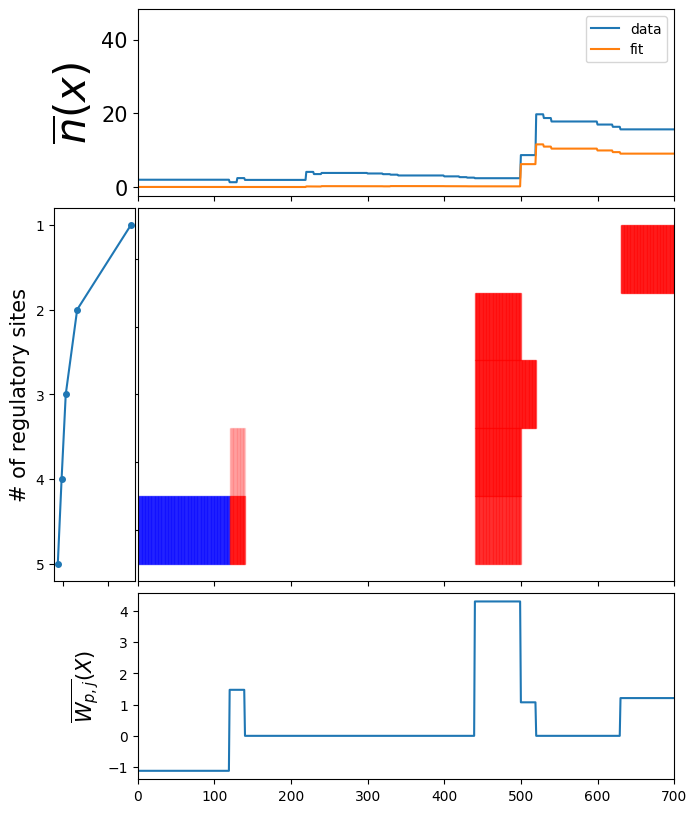

In [69]:
#Plotting the results
fig = plt.figure(figsize=(8, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[0.6,1.2,0.6], width_ratios=[0.15, 1])
plt.subplots_adjust(hspace=0.05, wspace=0.01)
ax3=fig.add_subplot(gs[1, 1])
ax1=fig.add_subplot(gs[0, 1])
ax2=fig.add_subplot(gs[1, 0])
ax1_5=fig.add_subplot(gs[2, 1])

   
All_nbar_predicted=[]

for i in range(len(number_of_sites)):
        
    X=Xs[i]
    Xb=Xbs[i]
    hs=Hs[i]
    number_of_site=number_of_sites[i]
    P_bound13=P_bound_calculator(X,hs,Xb,counts,tile_beginning,tile_end,libvalues,hp)
    nbar_predicted=average_per_base_pair(tile_beginning,tile_end,np.max(counts)*P_bound13,libvalues)  
    All_nbar_predicted.append(nbar_predicted)

    union_start_end=breaking_locations(tile_beginning,tile_end)
    union_start_end2=[]
    

    for tk in range(int(union_start_end[-1]-union_start_end[0]+1)):
        
        union_start_end2.append(union_start_end[0]+tk)
        
    union_start_end2=np.array((union_start_end2))
    
    ppppp=0
    kdfks=0
    mamam=[]
    kamal=[]


    state3=start_end_to_state(union_start_end,X,Xb,hs)
    
    State=state_to_State(union_start_end,state3)

    maxx=np.max(state3)
    minn=np.min(state3)
    state3=np.copy(State)
                        
    ttttttt=np.max([abs(maxx),abs(minn)])
    for o in range(len(state3)):
        
        vc=state3[o]
        
        if vc!=0:
            if vc>0:
                

                x1=+o+union_start_end[0]
                x2=+o+1+union_start_end[0]
                y1=len(number_of_sites)+1-i

                ax3.fill([x1,x2,x2,x1],[y1-0.5,y1-0.5,y1+0.5,y1+0.5],color='r',alpha=(0.5*state3[o])/ttttttt)
            if vc<0:

                x1=o+union_start_end[0]
                x2=o+1+union_start_end[0]
                y1=len(number_of_sites)+1-i
                ax3.fill([x1,x2,x2,x1],[y1-0.5,y1-0.5,y1+0.5,y1+0.5],color='b',alpha=((-0.5*state3[o]))/(ttttttt))
    
 
nbar=average_per_base_pair(tile_beginning,tile_end,counts,libvalues)
ax1.plot(np.arange(len(nbar))+union_start_end[0],nbar,label='data')

ax1.plot(np.arange(len(nbar_predicted))+union_start_end[0],np.mean(All_nbar_predicted,axis=0),label='fit')

cc=np.arange(len(Es))
cc=cc[::-1]+2
ax2.plot(Es,cc,'o-',markersize=4)

ax2.set_ylabel(r'# of regulatory sites',fontsize=15)

ax1.set_ylabel(r'$\overline{n}(x)$',fontsize=30)

ax1_5.set_ylabel(r'$\overline{W_{p,j}}(X)$',fontsize=15)


ttt=[]
yyy=[]
for m in range(len(number_of_sites)):

    ttt.append(str(number_of_sites[len(number_of_sites)-1-m]))
    yyy.append(m+2)
ax2.set_yticks(yyy,ttt)  


ax1.tick_params(axis='both', which='major', labelsize=15)

ax1.set_xticklabels([]) 

ax3.set_xticklabels([])

ax2.set_xticklabels([])

ax1.legend()
nami=[]
for i in range(len(number_of_sites)):
    X=Xs[i]
    Xb=Xbs[i]
    hs=Hs[i]

    state3=start_end_to_state(union_start_end,X,Xb,hs)

    
    State=state_to_State(union_start_end,state3)

    nami.append(State)

ss=np.mean(nami,axis=0)

ax1_5.plot(np.arange(len(ss))+union_start_end[0],ss)

ax1_5.set_xlim(start_of_the_region,end_of_the_region)
ax1.set_xlim(start_of_the_region,end_of_the_region)
ax3.set_xlim(start_of_the_region,end_of_the_region)

plt.savefig('results.pdf',dpi=300)
